# Problem Set 4, due February 23 at 11:59am, mid-day, noon.

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions.
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 3.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

Name: Shuyang Wu

Date: 2/14/2017

Section: C

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Getting oriented

Use different learning rates

### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [1]:
# uncomment the following if you want to see a lengthy description of the dataset
#print(bdata.keys())
#print(bdata.feature_names)
print(bdata.data.shape)
#print(bdata.target.shape)
print(bdata.DESCR)

# Your code here
df = pd.DataFrame(bdata.data)
df.columns = bdata.feature_names[:]

house = pd.DataFrame(bdata.target)
house.columns = ['MEDV']

df = pd.concat([df, house], axis=1)

#(a)regressing the housing price on the number of rooms per house
lm = smf.ols(formula='MEDV ~ RM', data=df).fit()
print(lm.params, '\n')

df['RMsqed'] = df['RM']**2
#(b)regressing the housing price on the number of rooms per house and the (number of rooms per house) squared
lm = smf.ols(formula='MEDV ~ RM + RMsqed', data=df).fit()
print(lm.params)

NameError: name 'bdata' is not defined

*Enter your observations here*

Regressing median house value on number of rooms: 

median house value = -34.67 + 9.1 * Number of Rooms. The number of rooms is positively associated with the house prices.

Regressing the housing price on the number of rooms per house and the (number of rooms per house) squared: 

median house value = 66.06 -22.64 * Number of Rooms + 2.47 * Number of Rooms^2. The number of rooms is negatively associated with the house prices, but the squared number of rooms is positively associated with house prices but with a smaller power (2.47 comparing to 9.1 from the previous regression).



### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 250-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 250 slope coefficients using a histogram with 25 bins, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

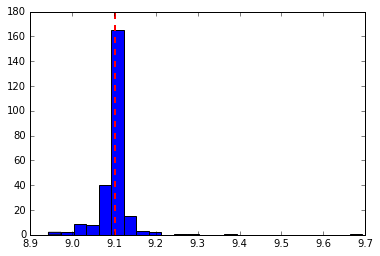

In [4]:
from sklearn.model_selection import KFold
# your code here
kf = KFold(n_splits=250)
slopes = []

for train, test in kf.split(df):
    X_train, X_test = df.iloc[train], df.iloc[test]
    lm = smf.ols(formula='MEDV ~ RM', data=X_train).fit()
    slopes.append(lm.params.get('RM'))

plt.hist(slopes, bins = 25)
plt.axvline(x=9.102109, color='r', linestyle='dashed', linewidth=2)

*Enter your observations here*

The slope I calculated with the entire dataset fits in the most frequent bin of slopes calculated from cross-validation. This means the estimated parameter 9.102109 is likely to be representative of the true paramter.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

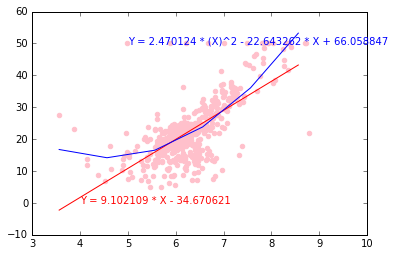

In [5]:
# Your code here
plt.scatter(df['RM'],df['MEDV'], color = 'pink')
X_plot = np.arange(df.RM.min(),df.RM.max())
plt.plot(X_plot, X_plot*9.102109-34.670621, color = 'r')
plt.text(4, 0, r'Y = 9.102109 * X - 34.670621', color = 'r')
plt.plot(X_plot, (X_plot*X_plot*2.470124) + (X_plot*-22.643262) + 66.058847, color = 'b')
plt.text(5, 50, r'Y = 2.470124 * (X)^2 - 22.643262 * X + 66.058847', color = 'b')

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

In [8]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
def bivariate_ols(xvalues, yvalues, R, MaxIterations):
    # initialize the parameters
    start_time = time.time()
    converged = False
    iter = 0
    m = len(xvalues) 
    beta = np.random.random(xvalues.shape[1])

    # Iterate Loop
    while not converged:
        J = xvalues.dot(beta) - yvalues
        grad = xvalues.T.dot(J)/m
       
        # update the theta_temp
        temp = beta - R * grad
    
        if (abs(temp - beta) <= 0.0001).all():
            print('Converged at iteration: ', iter)
            converged = True
    
        beta = temp   # update error 
        iter += 1  # update iter
    
        if iter == MaxIterations:
            print('Max interactions exceeded, did not converge.')
            converged = True
            
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds")
    alpha = beta[-1]
    beta = beta[:-1]
    return alpha, beta

# example function call
ones = np.ones(df.shape[0])
X = np.concatenate((df,ones[:, None]), axis = 1)
X = X[:, (5, -1)]
Y = np.array(df['MEDV'])
print('When R = 0.01')
print(bivariate_ols(X, Y, 0.01, 10000000))

print('\n','When R = 0.02')
print(bivariate_ols(X, Y, 0.02, 10000000))

print('\n','When R = 0.001')
print(bivariate_ols(X, Y, 0.001, 10000000))

When R = 0.01
Converged at iteration:  31252
Time taken: 0.67 seconds
(-33.839026020569712, array([ 8.97137807]))

 When R = 0.02
Converged at iteration:  18507
Time taken: 0.6 seconds
(-34.254887890404511, array([ 9.03675366]))

 When R = 0.001
Converged at iteration:  122107
Time taken: 2.41 seconds
(-26.353843249632209, array([ 7.79466939]))


*Enter your observations here*

The convergence iteration and running time increased as R value decreases (number of iteration increased from 18507 to 122107 while R decreased from 0.02 to 0.001; running time increased from 0.6 sec to 2.41 sec). Smaller learning rate/step size means the amount of change made in each iteration is smaller, which leads to more iterations to reach the same goal.


### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [7]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [8]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R, MaxIterations):
    start_time = time.time()
    converged = False
    iter = 0
    m = len(xvalue_matrix) 
    beta = np.random.random(xvalue_matrix.shape[1])

    # Iterate Loop
    while not converged:
        J = xvalue_matrix.dot(beta) - yvalues
        grad = xvalue_matrix.T.dot(J)/m
       
        # update the theta_temp
        temp = beta - R * grad

        if (abs(temp - beta) <= 0.0001).all():
            print('Converged at iteration: ', iter)
            converged = True
    
        beta = temp   # update error 
        iter += 1  # update iter
    
        if iter == MaxIterations:
            print('Max interactions exceeded, did not converge.')
            converged = True
            
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds")
    alpha = beta[-1]
    beta = beta[:-1]
    return alpha, beta

X = standardize(bdata.data[:,(0,5)])
ones = np.ones(X.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = bdata.target[:]
print('When R = 0.001')
print(multivariate_ols(X, Y, 0.001, 100000))

print('\n','When R = 0.01')
print(multivariate_ols(X, Y, 0.01, 100000))

print('\n','When R = 0.1')
print(multivariate_ols(X, Y, 0.1, 100000))

When R = 0.001
Converged at iteration:  5394
Time taken: 0.12 seconds
(22.432929691170823, array([-2.26479013,  5.86754342]))

 When R = 0.01
Converged at iteration:  767
Time taken: 0.02 seconds
(22.522976301102926, array([-2.25145497,  5.89084176]))

 When R = 0.1
Converged at iteration:  95
Time taken: 0.0 seconds
(22.531933170458924, array([-2.24912505,  5.893868  ]))


*Enter your observations here*

The convergence iteration and running time increased as R value decreases (number of iteration increased from 96 to 5412 while R decreased from 0.1 to 0.001; running time increased from 0.0 sec to 0.22 sec). Smaller learning rate/step size means the amount of change made in each iteration is smaller, which leads to more iterations to reach the same goal.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [9]:
# Your code here
X = bdata.data[:,(0,5)]
ones = np.ones(X.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = bdata.target[:]
print('When R = 0.001')
print(multivariate_ols(X, Y, 0.001, 1000000), '\n')

print('When R = 0.01')
print(multivariate_ols(X, Y, 0.01, 1000000), '\n')

print('When R = 0.1')
print(multivariate_ols(X, Y, 0.1, 1000000), '\n')

When R = 0.001
Converged at iteration:  110273
Time taken: 1.95 seconds
(-20.375730710956955, array([-0.29163778,  7.0102108 ])) 

When R = 0.01
Converged at iteration:  31347
Time taken: 0.59 seconds
(-28.409255132595469, array([-0.26480382,  8.25882586])) 

When R = 0.1
Max interactions exceeded, did not converge.
Time taken: 19.61 seconds
(nan, array([ nan,  nan])) 



*Enter your observations here*

Without normalization, the running time became much longer (e.g. when R = 0.001, running time with normalization versus without is 0.11 vs 1.86) and convergence took more iterations to be reached (e.g. when R = 0.001, iteration of convergence with normalization versus without is 5384th vs 108591th).

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients, it would be wise for you to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

In [10]:
# Your code here
from sklearn.model_selection import train_test_split
std_bdata = standardize(bdata.data)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(std_bdata, bdata.target, test_size = 0.34, random_state=42)
X = Xtrain[:,(0,5)]
ones = np.ones(X.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = Ytrain[:]
print(multivariate_ols(X, Y, 0.001, 100000))

Converged at iteration:  5370
Time taken: 0.12 seconds
(22.459925368517752, array([-2.44824656,  5.90566875]))


*Discuss your results here*

Training on 66% of the dataset produced similar results comparing to using the whole dataset. 

Using the entire dataset:  (When R = 0.001)

(22.432993121063181, array([-2.26143419,  5.8706921 ]))

Using just the taining set:

(22.459998372857232, array([-2.45425446,  5.90172244]))

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above and compare the actual to the predicted values for just the test instances. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [11]:
# Your code here
pred = -2.44089124*Xtest[:,0] + 5.91048075*Xtest[:,5] + 22.45981643
np.sqrt(((pred - Ytest) ** 2).mean())

5.7700287296345092

*Discuss your results here*

The test RMSE is 5.77, better (smaller) than the performance of the nearest neighbor algorithm from the last problem set, which was 7.82 before normalization and 9.693 after normalization. I think gradient descent allowed the model to reach global minimun which was not an option with nearest neighbor algorithm.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have *K+K^2/2* features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [13]:
##Step 1
features = pd.DataFrame(bdata.data)
features.columns = bdata.feature_names[:]
outcome = pd.DataFrame(bdata.target)
outcome.columns = ['MEDV']

for i in features:
    for j in features:
        if i != j:
            outcome[i+'_'+j] = df[i] * df[j]

big = pd.concat([features, outcome], axis=1)
big_std = standardize(big.ix[:, big.columns != 'MEDV'])
big_std['MEDV'] = big['MEDV']

##Step 2
big_train, big_test = train_test_split(big_std, test_size = 0.34, random_state=42)


### 4.2 Let's overfit!
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those *K+K/2* features as you can.  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [14]:
#first 5 features
X = big_train.ix[:, 0:5]
ones = np.ones(big_train.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = big_train['MEDV']
print('Regressed on first 5 features')
a, b = multivariate_ols(X, Y, 0.001, 100000)
print('alpha = ', a, '\nbeta = ', b)
pred = (np.matrix(big_test.ix[:,0:5])) * (np.matrix(b)).T
pred = np.array(pred) + a
RMSE5 = np.sqrt(((pred - np.array(big_test['MEDV'])) ** 2).mean())
print('RMSE = ', RMSE5, '\n')

#first 10 features
X = big_train.ix[:, 0:10]
ones = np.ones(big_train.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = big_train['MEDV']
print('Regressed on first 10 features')
a, b = multivariate_ols(X, Y, 0.001, 100000)
print('alpha = ', a, '\nbeta = ', b)
pred = (np.matrix(big_test.ix[:,0:10])) * (np.matrix(b)).T
pred = np.array(pred) + a
RMSE10 = np.sqrt(((pred - np.array(big_test['MEDV'])) ** 2).mean())
print('RMSE = ', RMSE10, '\n')

#first 20 features
X = big_train.ix[:, 0:20]
ones = np.ones(big_train.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = big_train['MEDV']
print('Regressed on first 20 features')
a, b = multivariate_ols(X, Y, 0.001, 100000)
print('alpha = ', a, '\nbeta = ', b)
pred = (np.matrix(big_test.ix[:,0:20])) * (np.matrix(b)).T
pred = np.array(pred) + a
RMSE20 = np.sqrt(((pred - np.array(big_test['MEDV'])) ** 2).mean())
print('RMSE = ', RMSE20, '\n')

#first 100 features
X = big_train.ix[:, 0:100]
ones = np.ones(big_train.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = big_train['MEDV']
print('Regressed on first 100 features')
a, b = multivariate_ols(X, Y, 0.001, 100000)
print('alpha = ', a, '\nbeta = ', b)
pred = (np.matrix(big_test.ix[:,0:100])) * (np.matrix(b)).T
pred = np.array(pred) + a
RMSE100 = np.sqrt(((pred - np.array(big_test['MEDV'])) ** 2).mean())
print('RMSE = ', RMSE100, '\n')

Regressed on first 5 features
Converged at iteration:  5440
Time taken: 0.96 seconds
alpha =  22.8263953739 
beta =  [-2.01161109  1.02518485 -2.14004196  2.31413609 -1.21866557]
RMSE =  10.2597046662 

Regressed on first 10 features
Converged at iteration:  10651
Time taken: 2.59 seconds
alpha =  22.5869767362 
beta =  [-1.35352758  1.16007025 -0.34531576  1.37152017 -1.35487774  4.92276364
 -1.65048231 -3.02607223 -0.10377917 -1.21078612]
RMSE =  11.1375455495 

Regressed on first 20 features
Converged at iteration:  12541
Time taken: 3.39 seconds
alpha =  22.4100948987 
beta =  [-0.03678582  0.48038652  0.43133883  0.06084733 -1.961301    2.94305199
 -0.59502883 -2.84117856  1.13893873 -0.77553548 -1.855002    0.92233092
 -3.66868561  0.44713247  0.91939807  1.23991895 -0.24356115 -1.13370055
  0.33832398 -0.85826012]
RMSE =  11.5513912653 

Regressed on first 100 features
Converged at iteration:  11283
Time taken: 3.82 seconds
alpha =  22.34616743 
beta =  [  1.90786112e-01  -3.219

*Discuss your results here*

Adding more features (5 to 100) increased the RMSE from 10.26 to 11.74. Comparing to when only using CRIM and RM as features, the RMSE increased by a large extent (from 5.77 to 10.26 and 11.74). Comparing to the nearest neighbor model which also only used CRIM and RM as features, the RMSE increased from 7.82 {before normalization) and 9.693 (after normalization) to 10.26 through 11.74. I think the increase in caused by introducing little important features which increased the dimensionality but not the prediction accuracy. Thus, the more features included, the higher the RMSE.

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 3.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [15]:
# Your code here
def multivariate_ols_ridge(xvalue_matrix, yvalues, lamda, R, MaxIterations=100000):
    start_time = time.time()
    converged = False
    iter = 0
    m = len(xvalue_matrix) 
    beta = np.random.random(xvalue_matrix.shape[1])

    # Iterate Loop
    while not converged:
        J = xvalue_matrix.dot(beta) - yvalues
        grad = xvalue_matrix.T.dot(J) + lamda * beta
       
        # update the theta_temp
        temp = beta - R * grad/m

        if (abs(temp - beta) <= 0.0001).all():
            print('Converged at iteration: ', iter)
            converged = True
    
        beta = temp   # update error 
        iter += 1  # update iter
    
        if iter == MaxIterations:
            print('Max interactions exceeded, did not converge.')
            converged = True
            
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds")
    alpha = beta[-1]
    beta = beta[:-1]
    return alpha, beta


std_bdata = standardize(bdata.data)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(std_bdata, bdata.target, test_size = 0.34, random_state=42)
X = Xtrain[:,(0,5)]
ones = np.ones(X.shape[0])
X = np.concatenate((X,ones[:, None]), axis = 1)
Y = Ytrain[:]
print('When lambda = 0.1')
print(multivariate_ols_ridge(X, Y, 0.1, 0.001, 100000))
pred = -2.45200156*Xtest[:,0] + 5.90295582*Xtest[:,5] + 22.453244444084891
print('RMSE = ', np.sqrt(((pred - Ytest) ** 2).mean()))

print("\n", 'When lambda = 1')
print(multivariate_ols_ridge(X, Y, 1, 0.001, 100000))
pred = -2.45651429*Xtest[:,0] + 5.88695804*Xtest[:,5] + 22.393691682381704
print('RMSE = ', np.sqrt(((pred - Ytest) ** 2).mean()))

print("\n", 'When lambda = 0.01')
print(multivariate_ols_ridge(X, Y, 0.01, 0.001, 100000))
pred = -2.44387942*Xtest[:,0] + 5.90891932*Xtest[:,5] + 22.459177766203517
print('RMSE = ', np.sqrt(((pred - Ytest) ** 2).mean()))

print("\n", 'When lambda = 10')
print(multivariate_ols_ridge(X, Y, 10, 0.001, 100000))
pred = -2.40869855*Xtest[:,0] + 5.79118048*Xtest[:,5] + 21.813659904385176
print('RMSE = ', np.sqrt(((pred - Ytest) ** 2).mean()))

When lambda = 0.1
Converged at iteration:  5359
Time taken: 0.27 seconds
(22.453340567994612, array([-2.45432801,  5.90086092]))
RMSE =  5.77101194067

 When lambda = 1
Converged at iteration:  5332
Time taken: 0.19 seconds
(22.393675029923983, array([-2.44266854,  5.89335013]))
RMSE =  5.77168549892

 When lambda = 0.01
Converged at iteration:  5389
Time taken: 0.14 seconds
(22.459269926028377, array([-2.44180617,  5.90845078]))
RMSE =  5.77029645113

 When lambda = 10
Converged at iteration:  5203
Time taken: 0.11 seconds
(21.813777313140459, array([-2.40647596,  5.7917622 ]))
RMSE =  5.8017490785


*Discuss your results here*

I changed the lambda value from 0.01, 0.1, 1 and 10, the changes in RMSE were minimal. The smallest RMSE is 5.7702 corresponding to lambda equals to 0.01. Comparing to the RMSE (which is around 11) from 4.2, RMSE is drastically smaller. I think because in 4.2, I included more features that are less important, they increased the dimensionality but also error rates. Comparing to the RMSE from 2.3 which is 5.770, the RMSE after ridge regularization, 5.7702, is actually a little bit bigger. I think it's because there are only two features fitted and they are both relatively important so regularization is not really necessary. Comparing to the RMSE from nearest neighbors, 7.82 before normalization and 9.693 after normalization, using gradient descent decreased the RMSE to 5.77.